<h1 style="text-align: center;">Hit Analyzer</h1>
<h2 style="text-align: center;">By: Thomas Giewont, Shreyas Vaidya, and Thomas Varano</h2>

<br>
<h3 style="text-align: center;">Introduction</h3>
<p> This is the Introduction. </p>

<h3 style="text-align: center;">Imports and Data Setup</h3>

In [64]:
import pandas as pd
import numpy as np
import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

<h3 style="text-align: center;">Data Collection and Curation</h3>

In [2]:
df = pd.read_csv('https://query.data.world/s/aofqalvgkuabshmmlxm32rxk3t3yiq')

In [3]:
df = df.drop(columns=['url'])
df = df.rename(columns={'WeekID': 'week', 'Week Position': 'week_position', 'Song': 'song', 'Performer': 'performer', 'SongID': 'songid', 'Instance': 'instance', 'Previous Week Position': 'prev_week_position', 'Peak Position': 'peak_position', 'Weeks on Chart': 'weeks_on_chart'})

In [4]:
df = df.astype({"week": 'datetime64'})

In [5]:
# stuff after 2000... obvi remove
df = df[df.week > pd.to_datetime(datetime.date(2000, 1, 1))]


In [6]:
# make a copy incase we fuck some data
dfcpy = df.copy()

In [7]:
# restore df
# df = dfcpy.copy()

<h3 style="text-align: center;">Data Analysis</h3>

#### Hypothesis:
We believe that every song follows a similar trend when they reach the Billboard Top 100.

In [8]:
pks = {}

for s in df.songid.unique(): 
    # order by week, 
    pks[s] = min(df[df.songid == s].peak_position.unique())

df.peak = np.nan
for i, r in df.iterrows():
    df.at[i, 'peak'] = pks[r['songid']]


In [9]:
df = df.drop(columns=['peak_position'])
df = df[df.peak <= 10]

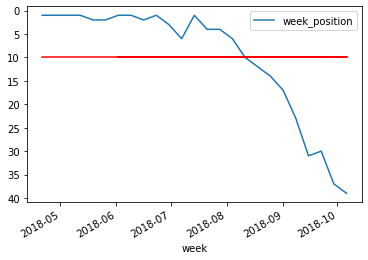

In [10]:
ax = plt.gca()
# for s in df.song.unique(): 
s = 'Nice For WhatDrake'
df[df.songid == s].plot(x='week', y='week_position', ax = ax)
horiz_line_data = np.array([10 for i in range(len(df[df.songid == s]))])
plt.plot(df[df.songid == s].week, horiz_line_data, 'r') 
plt.gca().invert_yaxis()
# print(min(pk))

In [11]:
# control points col
# (start, start_peak, end_peak, end)


In [12]:
# finding time before peak
# find when week_position == peak
# find the smallest weekid for my song
# subtract

# first hot week
# df.days_to_hot = np.nan

control_pts = {}

for s in df.songid.unique():

    song_instances = df[df.songid == s].sort_values(by='week')

    if len(song_instances[song_instances.week_position <= 10].week) != 0: 
        week = 1
        
        # get all peaks and their weeks
        # inflection points of graph in form: 
        # tuple (date, begin), where begin is true if the inflection point is beginning a hot spell
        inflections = []
        longest_peak = []

        # if the first week is already in the top 10
        if song_instances.iloc[0].week_position <= 10: 
            inflections.append((song_instances.iloc[0].week, True))


        for i in range(1, len(song_instances)): 
                
            if song_instances.iloc[i].week_position <= 10 and song_instances.iloc[i - 1].week_position > 10: 
                # this is for grace period
                if i > 1 and song_instances.iloc[i-2].week_position <= 10: 
                    # remove the last ending guy
                        inflections.remove(inflections[len(inflections) - 1])
                else: 
                    # if not beginning after a grace period, 
                    inflections.append((song_instances.iloc[i].week, True))
            elif song_instances.iloc[i].week_position > 10 and song_instances.iloc[i - 1].week_position <= 10:
                inflections.append((song_instances.iloc[i - 1].week, False))
   
        # if the song finished in the top 10 and dropped off the charts
        if song_instances.iloc[len(song_instances) - 1].week_position <= 10: 
            inflections.append((song_instances.iloc[len(song_instances) - 1].week, False))

        for i in range(0, len(inflections)-1):
            longest_date = datetime.timedelta(0)
            if len(inflections) == 0 or len(inflections) == 1:
                longest_peak = inflections
            else:
                # TODO look for better ways to find relevant peak (eg. height, top position, etc)
                if inflections[i][1] is True and inflections[i+1][1] is False:
                    if inflections[i+1][0] - inflections[i][0] >= longest_date:
                        longest_date = inflections[i+1][0] - inflections[i][0]
                        longest_peak = []
                        longest_peak.append(inflections[i])
                        longest_peak.append(inflections[i+1])

            # longest peak is relevant peak we care about

        control_pts[s] = (min(song_instances.week), max(song_instances.week), longest_peak[0][0], longest_peak[1][0])
    
        
        # print(s)
        # print(longest_peak)         
                

In [13]:
# insert into the df

for i, r in df.iterrows(): 
    # TODO delete the next line when doing whole calc
    if r.songid not in control_pts: continue
    ctrl_s = control_pts[r.songid]
    df.at[i, 'start_week'] = ctrl_s[0]
    df.at[i, 'end_week'] = ctrl_s[1]
    df.at[i, 'start_peak'] = ctrl_s[2]
    df.at[i, 'end_peak'] = ctrl_s[3]

In [14]:
df

,week,week_position,song,performer,songid,instance,prev_week_position,weeks_on_chart,peak,start_week,end_week,start_peak,end_peak
17,2019-12-07,11,Dance Monkey,Tones And I,Dance MonkeyTones And I,1.0,19.0,8.0,9.0,2019-10-19,2020-06-20,2020-01-11,2020-03-14
22,2005-10-15,11,Run It!,Chris Brown,Run It!Chris Brown,1.0,24.0,8.0,1.0,2005-08-27,2006-05-13,2005-10-22,2006-02-11
27,2010-03-27,12,Baby,Justin Bieber Featuring Ludacris,BabyJustin Bieber Featuring Ludacris,1.0,14.0,8.0,5.0,2010-02-06,2010-06-19,2010-04-03,2010-04-24
28,2018-04-07,12,Pray For Me,The Weeknd & Kendrick Lamar,Pray For MeThe Weeknd & Kendrick Lamar,1.0,10.0,8.0,7.0,2018-02-17,2018-06-30,2018-02-17,2018-03-31
34,2012-09-08,12,Blow Me (One Last Kiss),P!nk,Blow Me (One Last Kiss)P!nk,1.0,12.0,8.0,5.0,2012-07-21,2013-01-19,2012-09-22,2012-11-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...
324811,2015-10-24,38,Same Old Love,Selena Gomez,Same Old LoveSelena Gomez,1.0,48.0,4.0,5.0,2015-10-03,2016-04-09,2015-12-19,2016-02-13
324859,2017-10-14,39,...Ready For It?,Taylor Swift,...Ready For It?Taylor Swift,1.0,34.0,4.0,4.0,2017-09-23,2018-01-27,2017-09-23,2017-09-23
324869,2011-01-08,39,Rocketeer,Far*East Movement Featuring Ryan Tedder,RocketeerFar*East Movement Featuring Ryan Tedder,1.0,41.0,4.0,7.0,2010-12-18,2011-04-30,2011-02-12,2011-02-19
324874,2003-04-05,39,Bring Me To Life,Evanescence Featuring Paul McCoy,Bring Me To LifeEvanescence Featuring Paul McCoy,1.0,43.0,4.0,5.0,2003-03-15,2003-10-18,2003-05-10,2003-07-26


In [15]:
# using control points, we can calc anything we want. 

In [16]:
# note we had to deal with prince popping back up on the charts after he died (and we might be dead by tomorrowsoko)
# dealt with those weirdly
# and then also guys that peaked one week and dipped

In [17]:
# make weeks to hot and weeks hot

for i, r in df.iterrows(): 
    df.at[i, 'weeks_to_hot'] = (r.start_peak - r.start_week).days / 7
    df.at[i, 'weeks_hot'] = (r.end_peak - r.start_peak).days / 7
    df.at[i, 'tail_weeks'] = (r.end_week - r.end_peak).days / 7

df = df.astype({"weeks_to_hot": 'float', "weeks_hot": 'float', "tail_weeks": 'float'})


In [23]:
df

,week,week_position,song,performer,songid,instance,prev_week_position,weeks_on_chart,peak,start_week,end_week,start_peak,end_peak,weeks_to_hot,weeks_hot,tail_weeks
17,2019-12-07,11,Dance Monkey,Tones And I,Dance MonkeyTones And I,1.0,19.0,8.0,9.0,2019-10-19,2020-06-20,2020-01-11,2020-03-14,12.0,9.0,14.0
22,2005-10-15,11,Run It!,Chris Brown,Run It!Chris Brown,1.0,24.0,8.0,1.0,2005-08-27,2006-05-13,2005-10-22,2006-02-11,8.0,16.0,13.0
27,2010-03-27,12,Baby,Justin Bieber Featuring Ludacris,BabyJustin Bieber Featuring Ludacris,1.0,14.0,8.0,5.0,2010-02-06,2010-06-19,2010-04-03,2010-04-24,8.0,3.0,8.0
28,2018-04-07,12,Pray For Me,The Weeknd & Kendrick Lamar,Pray For MeThe Weeknd & Kendrick Lamar,1.0,10.0,8.0,7.0,2018-02-17,2018-06-30,2018-02-17,2018-03-31,0.0,6.0,13.0
34,2012-09-08,12,Blow Me (One Last Kiss),P!nk,Blow Me (One Last Kiss)P!nk,1.0,12.0,8.0,5.0,2012-07-21,2013-01-19,2012-09-22,2012-11-03,9.0,6.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
324811,2015-10-24,38,Same Old Love,Selena Gomez,Same Old LoveSelena Gomez,1.0,48.0,4.0,5.0,2015-10-03,2016-04-09,2015-12-19,2016-02-13,11.0,8.0,8.0
324859,2017-10-14,39,...Ready For It?,Taylor Swift,...Ready For It?Taylor Swift,1.0,34.0,4.0,4.0,2017-09-23,2018-01-27,2017-09-23,2017-09-23,0.0,0.0,18.0
324869,2011-01-08,39,Rocketeer,Far*East Movement Featuring Ryan Tedder,RocketeerFar*East Movement Featuring Ryan Tedder,1.0,41.0,4.0,7.0,2010-12-18,2011-04-30,2011-02-12,2011-02-19,8.0,1.0,10.0
324874,2003-04-05,39,Bring Me To Life,Evanescence Featuring Paul McCoy,Bring Me To LifeEvanescence Featuring Paul McCoy,1.0,43.0,4.0,5.0,2003-03-15,2003-10-18,2003-05-10,2003-07-26,8.0,11.0,12.0


KeyError: "None of [Index(['tail'], dtype='object')] are in the [columns]"

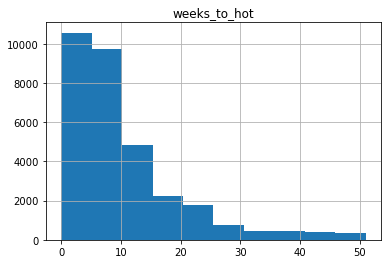

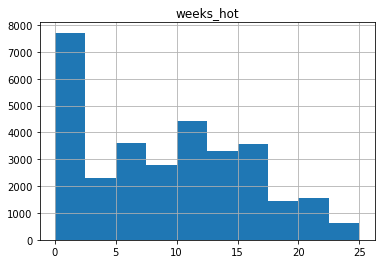

In [42]:
# a couple graphs to make pretty and look at
df[df.weeks_to_hot <= 52].hist(column='weeks_to_hot')
df[df.weeks_hot <= 25].hist(column='weeks_hot')
df[df.tail_weeks <= 52].hist(column='tail')

<h3 style="text-align: center;">Insights Attained</h3>

In [41]:
df.head(1)

,week,week_position,song,performer,songid,instance,prev_week_position,weeks_on_chart,peak,start_week,end_week,start_peak,end_peak,weeks_to_hot,weeks_hot,tail_weeks
17,2019-12-07,11,Dance Monkey,Tones And I,Dance MonkeyTones And I,1.0,19.0,8.0,9.0,2019-10-19,2020-06-20,2020-01-11,2020-03-14,12.0,9.0,14.0


In [ ]:
# Categories to look at
# instance 6
# weeks_on 5 
# peak 4
# weeks_to_hot 2 
# weeks_hot  1
# tail_weeks 3


In [91]:
train = pd.DataFrame(columns =['peak', 'weeks_on_chart', 'weeks_hot', 'weeks_to_hot', 'instance', 'tail_weeks' ])

for s in df.songid.unique():
    temp = df[df.songid == s]
    train = train.append({'peak': max(temp.peak), 'weeks_on_chart': max(temp.weeks_on_chart), 'weeks_hot' : max(temp.weeks_hot), \
                  'weeks_to_hot' : max(temp.weeks_to_hot), 'instance': max(temp.instance), 'tail_weeks' : max(temp.tail_weeks)}, ignore_index = True)



In [92]:
train2 = train.copy()

In [105]:
train2.dropna(inplace=True)
model = KMeans(n_clusters=10)
model.fit(train2.to_numpy())
all_predictions = model.predict(train2.to_numpy())
print(all_predictions)

[3 0 3 ... 0 3 0]


(array([185.,   3.,   1., 343.,   2.,   3., 370.,  49.,   1., 168.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

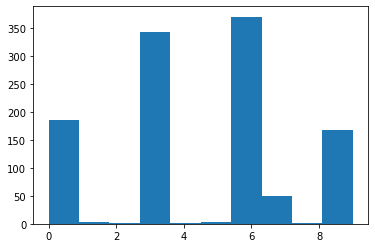

In [106]:
plt.hist(all_predictions)